In [1]:
import requests
import pandas as pd
from urllib.parse import urlencode
import tempfile
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#получаем датасеты по ссылкам
def read_df_on_yandex(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 

    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 

    download_response = requests.get(download_url) 

    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(download_response.content)
        temp_file_path = f.name

    df = pd.read_csv(temp_file_path)
    return df

assessments = read_df_on_yandex('https://disk.yandex.ru/d/iSVP1sZ7AdW7TQ')
courses = read_df_on_yandex('https://disk.yandex.ru/d/jmJxR8yhwCXlaw')
studentAssessment = read_df_on_yandex('https://disk.yandex.ru/d/DYd4M5b_8RETsA')
studentRegistration = read_df_on_yandex('https://disk.yandex.ru/d/lqHnH8NOZ458iw')

In [3]:
#Задание 1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене)

In [4]:
#берем экзамены
assessments_exam = assessments[assessments['assessment_type'] == 'Exam']

In [5]:
#соединяем по id экзамена со студентами, чтобы получить их id
assessments_exam_merge = assessments_exam.merge(studentAssessment, on='id_assessment')

In [6]:
#Оценка ниже 40 неудачная/неуспешная сдача теста. Фильтруем только тех кто успешно сдал экзамен
success_exam = assessments_exam_merge.query('score >= 40')

In [7]:
#берем студентов, которые не забросили учёбу и закончили курс
studentRegistration_finish = studentRegistration[studentRegistration['date_unregistration'].isna()]

In [8]:
#соединяем таблицы успешно сдавших экзамен и не забросивших курс
success_exam_and_reg = studentRegistration_finish.merge(success_exam, on=['id_student', 'code_module', 'code_presentation'])

In [9]:
#считаем кол-во учащихся у которых не более одного успешно сданного курса
success_exam_and_reg_count = success_exam_and_reg.groupby('id_student')['code_module'].nunique()
success_exam_and_reg_count[success_exam_and_reg_count <= 1].count()

3805

In [10]:
#Задание 2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса,
#которые обладают самой низкой и самой высокой завершаемостью

In [11]:
# посчитаем количество попыток сдачи экзаменов для каждого курса и экзамена
attempts_per_exam = assessments_exam_merge.groupby(['code_module', 'code_presentation', 'id_assessment', 'assessment_type']).size().reset_index(name='attempts')
attempts_per_exam

,code_module,code_presentation,id_assessment,assessment_type,attempts
0,CCC,2014B,24290,Exam,747
1,CCC,2014J,24299,Exam,1168
2,DDD,2013B,25340,Exam,602
3,DDD,2013J,25354,Exam,968
4,DDD,2014B,25361,Exam,524
5,DDD,2014J,25368,Exam,950


In [12]:
# посчитаем количество успешных экзаменов для каждого курса и экзамена
passed_per_exam = assessments_exam_merge[assessments_exam_merge['score'] >= 40].groupby(['code_module', 'code_presentation', 'id_assessment', 'assessment_type']).size().reset_index(name='passed')
passed_per_exam

,code_module,code_presentation,id_assessment,assessment_type,passed
0,CCC,2014B,24290,Exam,664
1,CCC,2014J,24299,Exam,1019
2,DDD,2013B,25340,Exam,504
3,DDD,2013J,25354,Exam,878
4,DDD,2014B,25361,Exam,485
5,DDD,2014J,25368,Exam,842


In [13]:
# объединим данные и посчитаем завершаемость для каждого экзамена
exam_completion = attempts_per_exam.merge(passed_per_exam, on=['code_module', 'code_presentation', 'id_assessment', 'assessment_type'], how='left')
exam_completion['completion_rate'] = exam_completion['passed'] / exam_completion['attempts']
exam_completion

,code_module,code_presentation,id_assessment,assessment_type,attempts,passed,completion_rate
0,CCC,2014B,24290,Exam,747,664,0.888889
1,CCC,2014J,24299,Exam,1168,1019,0.872432
2,DDD,2013B,25340,Exam,602,504,0.837209
3,DDD,2013J,25354,Exam,968,878,0.907025
4,DDD,2014B,25361,Exam,524,485,0.925573
5,DDD,2014J,25368,Exam,950,842,0.886316


In [14]:
# найдем экзамены с максимальной и минимальной завершаемостью
easiest_exam = exam_completion.loc[exam_completion['completion_rate'].idxmax()]
hardest_exam = exam_completion.loc[exam_completion['completion_rate'].idxmin()]

In [15]:
easiest_exam

code_module               DDD
code_presentation       2014B
id_assessment           25361
assessment_type          Exam
attempts                  524
passed                    485
completion_rate      0.925573
Name: 4, dtype: object

In [16]:
hardest_exam

code_module               DDD
code_presentation       2013B
id_assessment           25340
assessment_type          Exam
attempts                  602
passed                    504
completion_rate      0.837209
Name: 2, dtype: object

In [17]:
# Задание 3. По каждому предмету определи средний срок сдачи экзаменов 
#(под сдачей понимаем последнее успешное прохождение экзамена студентом)

In [18]:
#определяем средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом)
assessments_exam_merge.query('score >= 40').groupby('code_module')['date_submitted'].mean()

code_module
CCC    239.345217
DDD    237.976006
Name: date_submitted, dtype: float64

In [19]:
# Задание 4. Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них.
# А также предметы с самым большим оттоком

In [20]:
#смотрим на кол-во уникальных регистраций по курсам(TOP-3)
popularity_registration = studentRegistration.groupby('code_module')['date_registration'].count().sort_values(ascending=False)
popularity_registration.head(3)

code_module
BBB    7900
FFF    7751
DDD    6257
Name: date_registration, dtype: int64

In [21]:
#смотрим на кол-во оттока по курсам(TOP-3)
popularity_unregistration = studentRegistration.groupby('code_module')['date_unregistration'].count().sort_values(ascending=False)
popularity_unregistration.head(3)

code_module
FFF    2380
BBB    2377
DDD    2235
Name: date_unregistration, dtype: int64

In [22]:
#Задание 5. Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью
#курсов и самыми долгими средними сроками сдачи курсов.

In [23]:
#Для нахождения семестра с самой низкой завершаемостью, можно использовать ранее составленную таблицу exam_completion
exam_completion

,code_module,code_presentation,id_assessment,assessment_type,attempts,passed,completion_rate
0,CCC,2014B,24290,Exam,747,664,0.888889
1,CCC,2014J,24299,Exam,1168,1019,0.872432
2,DDD,2013B,25340,Exam,602,504,0.837209
3,DDD,2013J,25354,Exam,968,878,0.907025
4,DDD,2014B,25361,Exam,524,485,0.925573
5,DDD,2014J,25368,Exam,950,842,0.886316


In [24]:
#Фильтруем по completion_rate и смотрим на интересующий нас code_presentation
exam_completion.sort_values('completion_rate')['code_presentation'].iloc[0]

'2013B'

In [25]:
#определяем самцый долгий средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом)
assessments_exam_merge.query('score >= 40').groupby('code_module')['date_submitted'].mean().sort_values(ascending=False).iloc[0]

239.34521687462865

In [26]:
# Задание 6. Часто для качественного анализа аудитории использую подходы,
# основанные на сегментации. Используя python, построй адаптированные RFM-кластеры студентов,
# чтобы качественно оценить свою аудиторию. В адаптированной кластеризации можешь выбрать следующие метрики:
# R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен. 
# Подробно опиши, как ты создавал кластеры. 
# Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.

In [27]:
assessments_exam_merge_rfm = assessments_exam_merge

In [28]:
assessments_exam_merge_rfm['Recency'] = assessments_exam_merge_rfm.groupby('code_module')['date_submitted'].apply(lambda x: (x.fillna(x.mean()) - x.mean()))
assessments_exam_merge_rfm['Frequency'] = np.where(assessments_exam_merge_rfm['score'] >= 40, 1, 0)
assessments_exam_merge_rfm['Monetary'] = assessments_exam_merge_rfm.groupby('code_module')['score'].apply(lambda x: (x.fillna(x.mean()) - x.mean()))

In [29]:
quintiles = assessments_exam_merge_rfm[['Recency']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'Recency': {0.2: -6.901445466491452,
  0.4: -0.9014454664914524,
  0.6: 4.098554533508548,
  0.8: 4.591122715404708}}

In [30]:
score_ranges = {
    range(0, 21): 1,
    range(21, 40): 2,
    range(40, 51): 3,
    range(51, 71): 4,
    range(71, 101): 5
}

assessments_exam_merge_rfm['M'] = assessments_exam_merge_rfm['score'].apply(
    lambda x: next((value for key, value in score_ranges.items() if x in key), None)
)

In [31]:
def r_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5

In [32]:
assessments_exam_merge_rfm['R'] = assessments_exam_merge_rfm['Recency'].apply(lambda x: r_score(x, 'Recency'))
assessments_exam_merge_rfm['F'] = assessments_exam_merge_rfm['Frequency']

In [33]:
assessments_exam_merge_rfm['RFM Score'] = assessments_exam_merge_rfm['R'].map(str) + assessments_exam_merge_rfm['F'].map(str) + assessments_exam_merge_rfm['M'].map(str)
assessments_exam_merge_rfm.date_submitted.mean()

238.4835652349264

In [34]:
segt_map = {
    r'[1-2][4-5]': 'Отлично',
    r'[4-5][3-4]': 'медленно и хорошо',
    r'[1-3][1-2]': 'не сдал, возможно поторопился',
    r'[1-3][3-4]' : 'нормально',
    r'1[1-2]': 'слишком быстро и неправильно',
    r'[3-5]5' : 'хорошая работа',
    r'[4-5][1-2]' : 'медленно и неправильно'       
}

assessments_exam_merge_rfm['Segment'] = assessments_exam_merge_rfm['R'].map(str) + assessments_exam_merge_rfm['M'].map(str)
assessments_exam_merge_rfm['Segment'] = assessments_exam_merge_rfm['Segment'].replace(segt_map, regex=True)

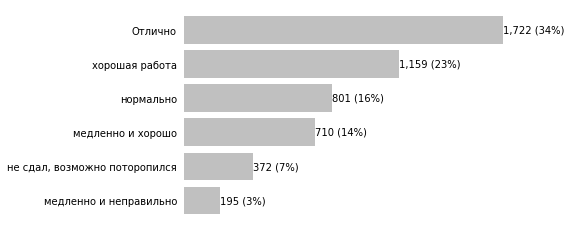

In [35]:
segments_counts = assessments_exam_merge_rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

#Подробно опиши, как ты создавал кластеры
Оценки М я пытался изначально создавать с помощью квантилей, но в оценку 2, попадали как люди у которых за экзамен больше 40 баллов, хоть и ненамного, так и люди у которых за экзамен менее 40 баллов, что является несдачей.
Класстеры в segt_map создавал на собственных убеждениях и внутреннем восприятии оценок, ставя себя на место людей, выбирал студента смотрел сколько получил, сколько по времени сдавал, прикидывал, что если бы у меня был такой результат, как бы я его назвал